# Statistical appearance modelling with pyssam

This statistical appearance modelling example uses a mean lung shape and visualises modes of appearance correlations in the left lower lung lobe. 
Appearance values are obtained from the gray-value at the pixel nearest to each landmark on a digitally reconstructed radiograph (DRR) that mimics a frontal (anterior-posterior) chest X-ray.
DRRs are created from the patient CT image data by integrating the voxel intensity over a chosen direction.
We done this using the script in [ZacharAdn/ct_2_xRay](https://github.com/ZacharAdn/ct_2_xRay).

In [1]:
import pyssam

In [2]:
from copy import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

First, we source landmark data to use in our shape model

In [3]:
LANDMARK_DIR = "../../example_data/lung_landmarks/"
XR_DIR = "../../example_data/reconstructed_xrays/"
# Get directories for DRR and landmark data
origin_dir_list = glob(f"{XR_DIR}/origins/origins/drr*.md")
spacing_dir_list = glob(f"{XR_DIR}/*/drr*.md")
im_dir_list = glob(f"{XR_DIR}/*/drr*.png")
origin_dir_list.sort()
spacing_dir_list.sort()
im_dir_list.sort()
# check that user has declared correct directory
patientIDs = [i.split("/")[-1].replace(".png", "")[-4:] for i in im_dir_list]
landmark_dir_list = glob(f"{LANDMARK_DIR}/landmarks*.csv")
landmark_dir_list = sorted(
  landmark_dir_list, key=lambda x: int(x.replace(".csv", "")[-4:])
)
# used to align drrs and landmarks
trans_dirs = glob(f"{XR_DIR}/transforms/transformParams_case*_m_*.dat")
trans_dirs.sort()

if (
  len(im_dir_list) == 0
  or len(origin_dir_list) == 0
  or len(landmark_dir_list) == 0
  or len(spacing_dir_list) == 0
):
  raise AssertionError(
    "ERROR: The directories you have declared are empty.",
    "\nPlease check your input arguments.",
  )

landmark_offset = np.vstack(
  [np.loadtxt(t, skiprows=1, max_rows=1) for t in trans_dirs]
)
# read data
origin = np.vstack([np.loadtxt(o, skiprows=1) for o in origin_dir_list])
spacing = np.vstack([np.loadtxt(o, skiprows=1) for o in spacing_dir_list])
# load x-rays into a stacked array,
# switch so shape is (num patients, x pixel, y pixel)
img_all = np.rollaxis(np.dstack([pyssam.utils.loadXR(o) for o in im_dir_list]), 2, 0)
landmark_coordinates = np.array(
  [np.loadtxt(l, delimiter=",") for l in landmark_dir_list]
)

# offset centered coordinates to same reference frame as CT data
landmark_align_to_projection = (
  landmark_coordinates + landmark_offset[:, np.newaxis]
)

In [4]:
from pyssam.utils import AppearanceFromXray
appearance_helper = AppearanceFromXray(
    img_all, 
    origin[:, [0, 2]], 
    spacing[:, [0, 2]]
)
appearance_scaled = appearance_helper.all_landmark_density(landmark_align_to_projection[:, :, [0, 2]])

using 2D coordinates for X-ray


In [5]:
print(pd.Series(appearance_scaled.flat).describe())

count    2.882880e+05
mean    -6.465595e-18
std      1.000002e+00
min     -2.707115e+00
25%     -8.872909e-01
50%     -1.225485e-01
75%      7.969093e-01
max      2.948324e+00
dtype: float64


## Initialising the model

Here we convert to landmark coordinates into a parameterised shape model. We first initialise the class, which handles all pre-processing. Then, we can compute the shape model components and mean population shape

In [6]:
# import pyssam
sam_obj = pyssam.SAM(appearance_scaled)
sam_obj.create_pca_model(sam_obj.appearance_columns_scale)
mean_appearance_columnvector = sam_obj.compute_dataset_mean()
shape_model_components = sam_obj.pca_model_components
ssm_obj = pyssam.SSM(landmark_coordinates)
mean_shape_columnvector = ssm_obj.compute_dataset_mean()
mean_shape = mean_shape_columnvector.reshape(-1, 3)

As a first check, we can analyse how much the appearance changes when we morph the first principal component by 2 * the standard deviation, which should have 0 mean and be roughly between +/- 3

In [7]:
shape_parameter_copy = copy(sam_obj.model_parameters)
shape_parameter_copy[0] = 2
appearance_i = sam_obj.morph_model(
    mean_appearance_columnvector, 
    shape_model_components, 
    shape_parameter_copy
)
print(pd.Series(np.squeeze(appearance_i) - mean_appearance_columnvector).describe())

count    6.006000e+03
mean     1.312451e-17
std      5.894403e-01
min     -1.657869e+00
25%     -3.763953e-01
50%     -6.159760e-03
75%      4.353855e-01
max      1.248995e+00
dtype: float64


## Plotting and analysis

In [8]:
# Define some plotting functions

def plot_cumulative_variance(explained_variance, target_variance=-1):
    number_of_components = np.arange(0, len(explained_variance))+1
    fig, ax = plt.subplots(1,1)
    color = "blue"
    ax.plot(number_of_components, explained_variance*100.0, marker="o", ms=2, color=color, mec=color, mfc=color)
    if target_variance > 0.0:
        ax.axhline(target_variance*100.0)
    
    ax.set_ylabel("Variance [%]")
    ax.set_xlabel("Number of components")
    ax.grid(axis="x")
    plt.show()
    
def plot_sam_modes(
  mean_appearance_columnvector, 
  mean_shape, 
  original_shape_parameter_vector,
  shape_model_components,
  show_difference=True,
):
  weights = [-2, 0, 2]
  fig, ax = plt.subplots(1, 3)
  for j, weights_i in enumerate(weights):
    shape_parameter_vector = copy(original_shape_parameter_vector)
    shape_parameter_vector[mode_to_plot] = weights_i
    mode_i_appearance = sam_obj.morph_model(
        mean_appearance_columnvector, 
        shape_model_components, 
        shape_parameter_vector
    )

    offset_appearance = (mean_appearance_columnvector - mode_i_appearance)
    if weights_i != 0 and show_difference:
      ax[j].scatter(
        mean_shape[:, 0],
        mean_shape[:, 2],
        c=offset_appearance,
        cmap="seismic",
        vmin=-1,
        vmax=1,
        s=1,
      )
    else:
        ax[j].scatter(
        mean_shape[:, 0],
        mean_shape[:, 2],
        c=mode_i_appearance,#"gray",
        cmap="gray",
        s=1,
        )
    if weights_i == 0:
        ax[j].set_title("mean shape")
    else:
        ax[j].set_title(f"mode {mode_to_plot} \nweight {weights_i}")

    ax[j].axis('off')
    ax[j].margins(0,0)
    ax[j].xaxis.set_major_locator(plt.NullLocator())
    ax[j].yaxis.set_major_locator(plt.NullLocator())

  plt.show()

Generally, the first part in assessing the model once trained is visualising how the explained variance changes with an increasing number of modes. If few modes are required, it means it will be much simpler to fit the SSM to an image.

To obtain 90.0% variance, 25 modes are required


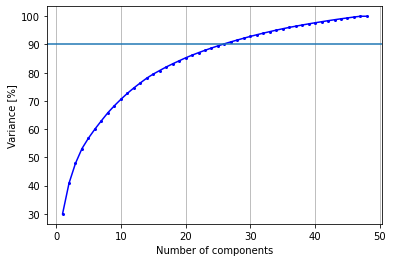

In [9]:
print(f"To obtain {sam_obj.desired_variance*100}% variance, {sam_obj.required_mode_number} modes are required")
plot_cumulative_variance(np.cumsum(sam_obj.pca_object.explained_variance_ratio_), 0.9)

Now the interesting part. We visualise the first three principal components, where the points are coloured by their displacement. 

explained variance is 0.29989861806741963


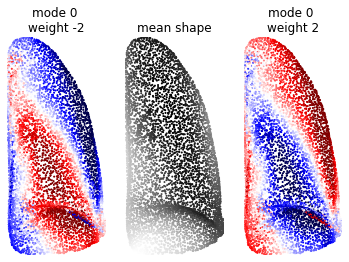

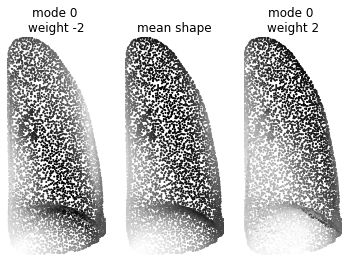

In [10]:
mode_to_plot = 0
print(f"explained variance is {sam_obj.pca_object.explained_variance_ratio_[mode_to_plot]}")

plot_sam_modes(
    mean_appearance_columnvector, 
    mean_shape, 
    sam_obj.model_parameters,
    sam_obj.pca_model_components,
)
plot_sam_modes(
    mean_appearance_columnvector, 
    mean_shape, 
    sam_obj.model_parameters,
    sam_obj.pca_model_components,
    show_difference=False,
)

explained variance is 0.10870635292491349


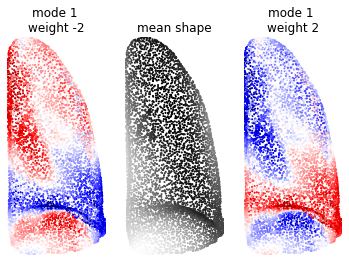

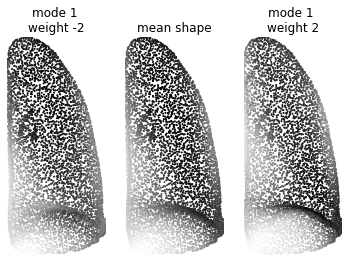

In [11]:
mode_to_plot = 1
print(f"explained variance is {sam_obj.pca_object.explained_variance_ratio_[mode_to_plot]}")

plot_sam_modes(
    mean_appearance_columnvector, 
    mean_shape, 
    sam_obj.model_parameters,
    sam_obj.pca_model_components,
)
plot_sam_modes(
    mean_appearance_columnvector, 
    mean_shape, 
    sam_obj.model_parameters,
    sam_obj.pca_model_components,
    show_difference=False,
)

explained variance is 0.07055566192886323


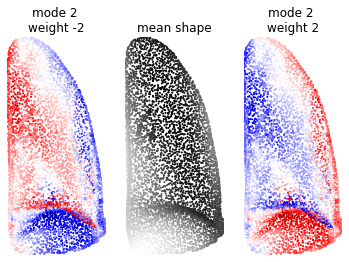

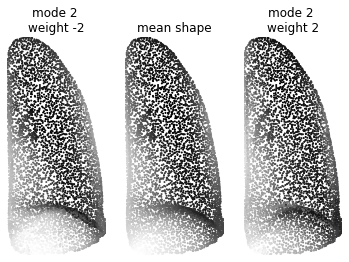

In [12]:
mode_to_plot = 2
print(f"explained variance is {sam_obj.pca_object.explained_variance_ratio_[mode_to_plot]}")

plot_sam_modes(
    mean_appearance_columnvector, 
    mean_shape, 
    sam_obj.model_parameters,
    sam_obj.pca_model_components,
)
plot_sam_modes(
    mean_appearance_columnvector, 
    mean_shape, 
    sam_obj.model_parameters,
    sam_obj.pca_model_components,
    show_difference=False,
)

When we look at the 15th mode, which accounts for around 1% for the total variance, we can see a very minor change in the lung structure (shown by very light red and blue patches).

explained variance is 0.012670181927269023


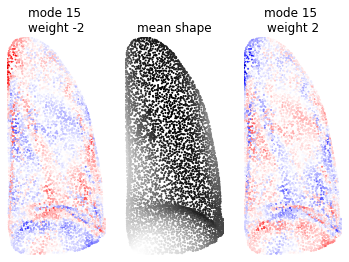

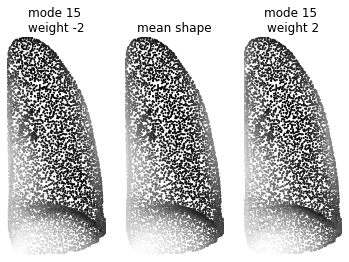

In [13]:
mode_to_plot = 15
print(f"explained variance is {sam_obj.pca_object.explained_variance_ratio_[mode_to_plot]}")

plot_sam_modes(
    mean_appearance_columnvector, 
    mean_shape, 
    sam_obj.model_parameters,
    sam_obj.pca_model_components,
)
plot_sam_modes(
    mean_appearance_columnvector, 
    mean_shape, 
    sam_obj.model_parameters,
    sam_obj.pca_model_components,
    show_difference=False,
)